# **💉INForcast** - Time Series Forcasting using Darts

### Importing Libraries and Package files

In [27]:
import pandas as pd
import darts
import seaborn as sns
import matplotlib.pyplot as plt
import os

from inforcast.params import *
from inforcast.ml_functions.preprocessor import *

# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
directory_path = "../data/"
file_list = os.listdir(directory_path)
file_list

['.DS_Store',
 'Influenza_Predictor_KMC.csv',
 'influenzaTCP.csv',
 'influenza_predictorECS.csv',
 'sampledata_all.csv',
 'influenzaSMW.csv',
 'influenzaTGP.csv',
 'sampledata.csv']

In [29]:
data = pd.read_csv(f'../data/influenza_predictorECS.csv')

In [30]:
data.head()

,Vaccination type,Event date,Date of birth,Event done at ID,Patient Count
0,Influenza Vaccine 1,25-Oct-2006,05-Aug-1961,C88069,1
1,Inactivated Influenza Vaccine (Split Virion) B...,25-Oct-2016,05-Aug-1961,E87750,1
2,Quadrivalent influenza vaccine Split Virion in...,15-Dec-2020,05-Aug-1961,E87750,1
3,Flucelvax Tetra (Seqirus UK) 1,14-Dec-2021,05-Aug-1961,E87750,1
4,Influenza Vaccine 1,10-Oct-2000,23-May-1990,B82609,1


### Loading function from `main.py`
To speed up processing.

In [31]:
data = process_dataframe(data)
data = update_location(data)

In [32]:
data.head()

,vaccine,date,dob,location,pt_count,age_at_vaccine
0,Influenza Vaccine 1,2006-10-25,1961-08-05,Elsewhere,1,45
1,Inactivated Influenza Vaccine (Split Virion) B...,2016-10-25,1961-08-05,E87750,1,55
2,Quadrivalent influenza vaccine Split Virion in...,2020-12-15,1961-08-05,E87750,1,59
3,Flucelvax Tetra (Seqirus UK) 1,2021-12-14,1961-08-05,E87750,1,60
4,Influenza Vaccine 1,2000-10-10,1990-05-23,Elsewhere,1,10


### Transform `data` into TimeSeries

In [33]:
time_s = to_timeseries_full(data, 'date')

In [34]:
time_s

,date,count
0,2000-10-31,23
1,2000-11-30,13
2,2000-12-31,9
3,2001-01-31,9
4,2001-02-28,0
...,...,...
275,2023-09-30,209
276,2023-10-31,146
277,2023-11-30,62
278,2023-12-31,28


In [35]:
time_s['count'] = time_s['count'] + 0.01

In [36]:
time_s['count'] = time_s['count'].astype('float32')

In [37]:
time_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    280 non-null    datetime64[ns]
 1   count   280 non-null    float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 3.4 KB


# **Darts** TimeSeries Package

### Libraries and initiating TimeSeries Object

In [38]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [39]:
series =  TimeSeries.from_dataframe(time_s, time_col='date', value_cols='count')

### Scaled with **Standard Scaler**

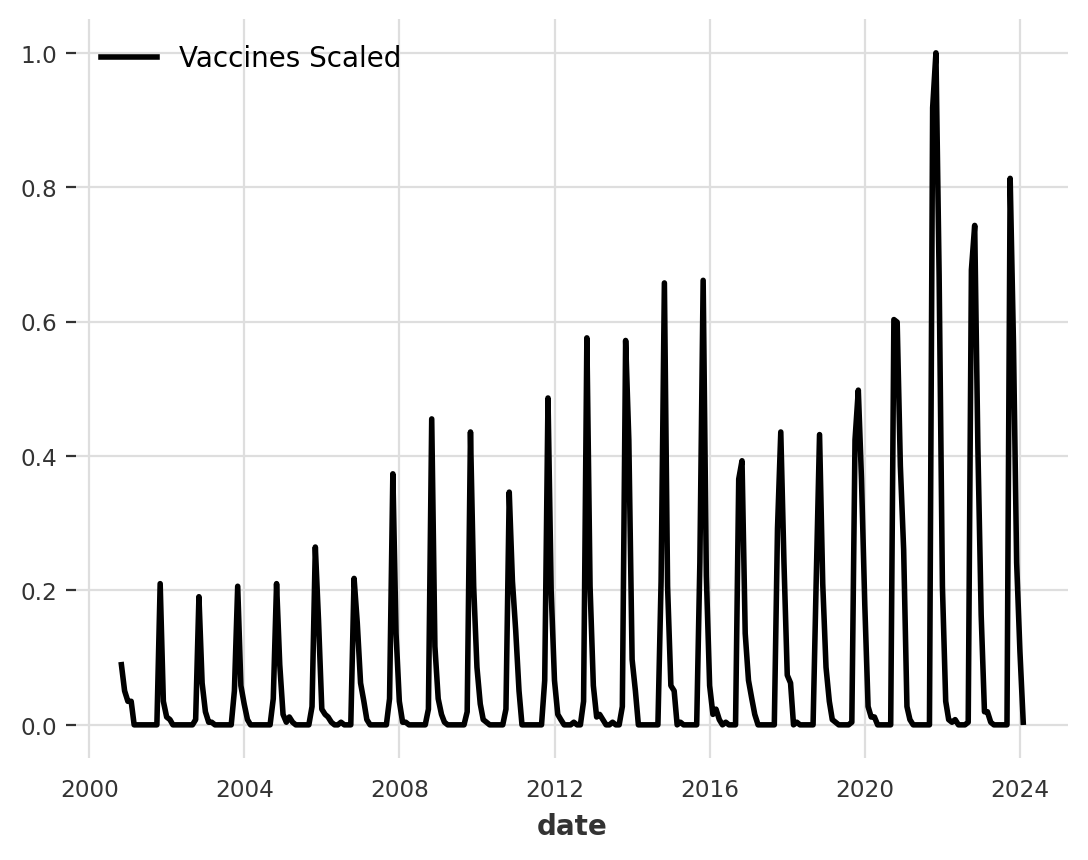

In [40]:
from darts.dataprocessing.transformers import Scaler

# creating scaler object
scaler_vacc = Scaler()
# prefroming the scaling
ts_scaled = scaler_vacc.fit_transform(series)
# plottingair_ds.plot(label="Number Of Passengers")
ts_scaled.plot(label = "Vaccines Scaled")
plt.legend();

**Diff Plot**

<Axes: xlabel='date'>

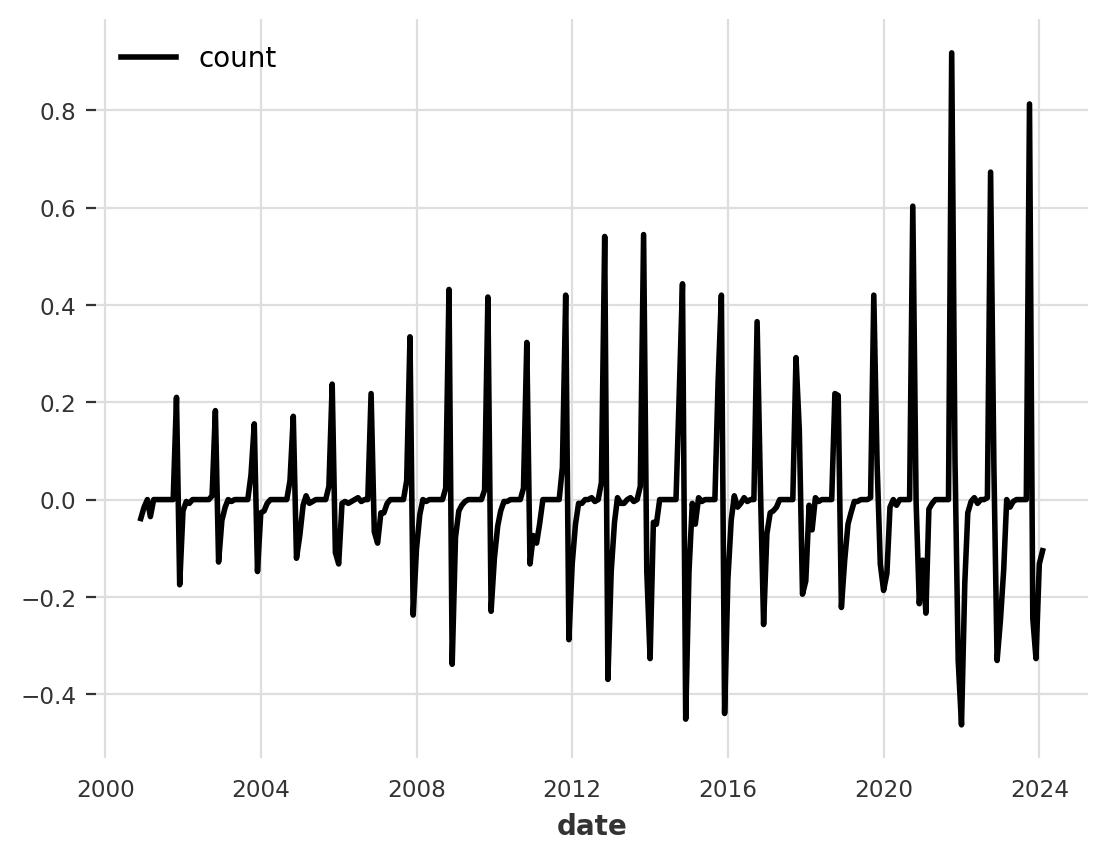

In [41]:
ts_scaled.diff().plot()

In [49]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load your time series data
# For demonstration, let's assume you have a pandas Series `ts` with your time series data.
# ts = pd.read_csv('path_to_your_data.csv', usecols=['column_of_interest'], squeeze=True)

# Convert the column to a pandas Series if it's not already (assuming the column name is 'your_time_series_column'):
# ts = pd.Series(df['your_time_series_column'].values)

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(ts)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results based on the p-value and critical values
if adf_test[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

<Axes: xlabel='date'>

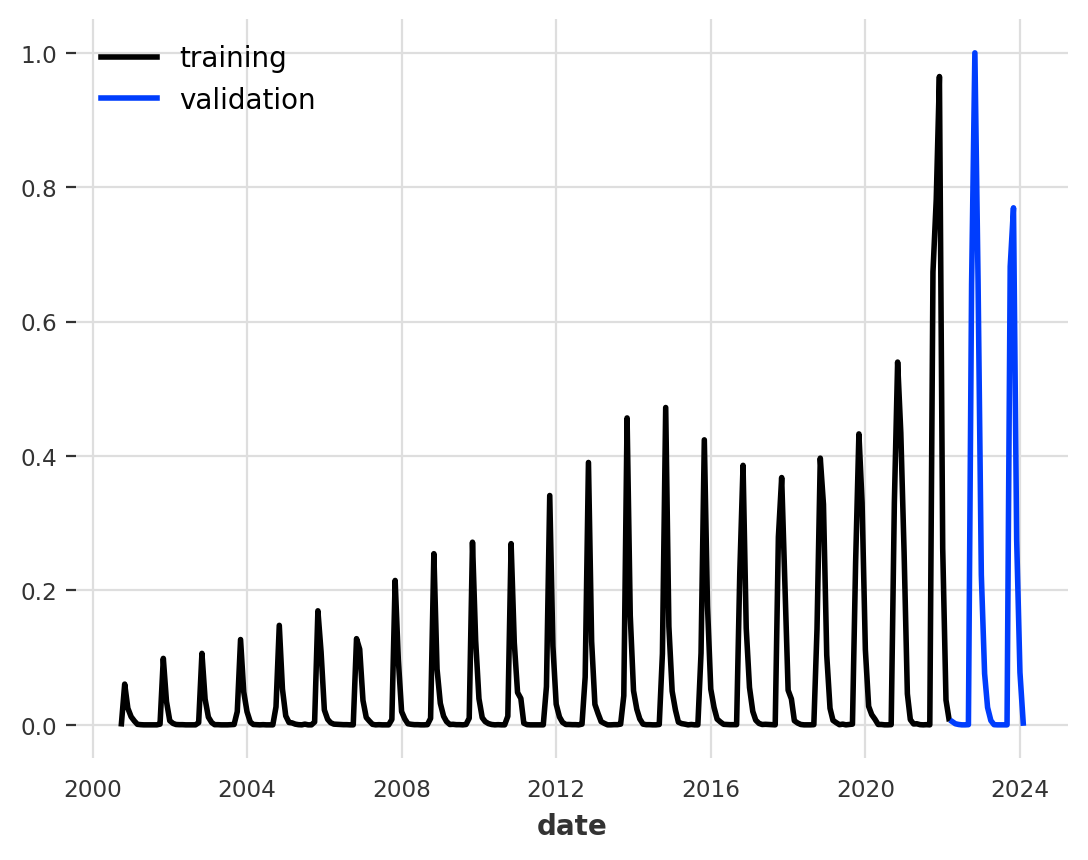

In [19]:
train, val = ts_scaled.split_after(0.92)
train.plot(label="training")
val.plot(label="validation")

## Using N-BEATS model
For our use case, we will go by the N-BEATS model provided as it supports multivariate time series forecasting(data having multiple features), which will allow us to perform all forecasting using a single model. So let’s load it.

In [42]:
# importing model
from darts.models import NBEATSModel

In [43]:
# creating a model object
model = NBEATSModel(input_chunk_length=24 , output_chunk_length=12, n_epochs = 100 , random_state = 15)

In [44]:
# fitting the model
model.fit([ts_scaled], verbose = True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |                                                                                               | 0/…

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=15)

## Predict Results +  Evaluation
MAPE - Mean Average Precession Error

In [45]:
# imports
from darts.metrics import mape

In [46]:
pred_vacc = model.predict(n = 24, series = ts_scaled)

print("Mape = {:.2f}%".format(mape(ts_scaled , pred_vacc)))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                             | 0/…

Mape = nan%


/Users/janduplessis/.pyenv/versions/3.10.6/envs/inforcast/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/janduplessis/.pyenv/versions/3.10.6/envs/inforcast/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Mape = nan%


/Users/janduplessis/.pyenv/versions/3.10.6/envs/inforcast/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/janduplessis/.pyenv/versions/3.10.6/envs/inforcast/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


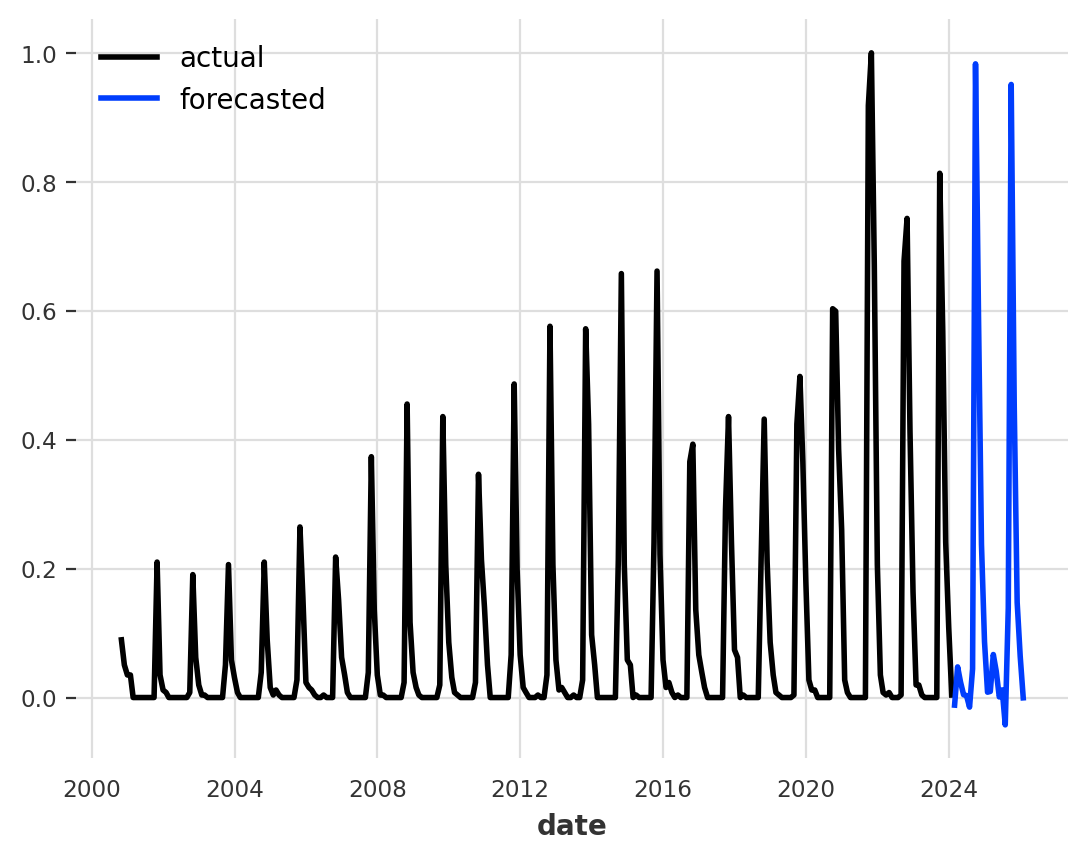

In [47]:
# plotting results
ts_scaled.plot(label = "actual")
pred_vacc.plot(label = "forecasted") # validation data set
plt.legend()

print("Mape = {:.2f}%".format(mape(train , pred_vacc)))

In [48]:
from darts import TimeSeries
from darts.models import Prophet
import pandas as pd

# Assuming you have a DataFrame `df` with a datetime index and a column 'y' with the values to forecast
# df = pd.read_csv('your_data.csv')
# df['time'] = pd.to_datetime(df['time'])  # Make sure that your time column is a datetime object
# df.set_index('time', inplace=True)

# Create a TimeSeries object from the DataFrame for Darts
ts = TimeSeries.from_dataframe(time_s, value_cols='count')

# Initialize the Prophet model
model = Prophet()

# Fit the model to the time series
model.fit(ts)

# Predict the next 12 months (assuming your data is monthly, adjust the number accordingly)
future = model.predict(n=12)

# Plot the forecast
import matplotlib.pyplot as plt

ts[-36:].plot(label='actual')  # Plot the last 3 years of actual data
future.plot(label='forecast')  # Plot the forecast
plt.legend()
plt.show()

ImportError: The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


ImportError: The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality
plot_acf(train, m=12, alpha=0.05)

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(60)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

In [ ]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(60)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")
plt.show()

In [ ]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(60)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")
plt.show()

In [ ]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

In [ ]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("sMAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

In [ ]:
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.4, forecast_horizon=12, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(model_es.residuals(series))
plt.show()

In [ ]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

In [ ]:
import numpy as np
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [ ]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

In [ ]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

In [ ]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

In [ ]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [ ]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

In [ ]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

# **Standard Scaling** with Darts

In [ ]:
from darts.dataprocessing.transformers import Scaler

# creating scaler object
scaler_vacc = Scaler()
# prefroming the scaling
ts_scaled = scaler_vacc.fit_transform(series)
# plottingair_ds.plot(label="Number Of Passengers")
ts_scaled.plot(label = "Vaccines Scaled")
plt.legend();

In [ ]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train, epochs=400, verbose=True);

In [ ]:
over_ts.reset_index(inplace=True)

In [ ]:
over_ts

In [ ]:
over_ts.info()

In [ ]:
series =  TimeSeries.from_dataframe(over_ts, time_col='date', value_cols='count')

In [ ]:
train, val = series.split_after(0.90)
train.plot(label="training")
val.plot(label="validation")

In [ ]:
from darts import TimeSeries
from darts.models import Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Assuming 'series' is your TimeSeries object.

# Create the Prophet model
model = Prophet()

# Fit the model to your series
model.fit(series)

# Define the length of the forecast horizon
# For example, to predict the next 24 months:
forecast_horizon = 24
series = series.resample('MS')
# Create a future time series (if your series has a DateTime index)
future_times = series.time_index[-1] + series.freq * np.arange(1, forecast_horizon + 1)
future_series = datetime_attribute_timeseries(future_times, attribute='day', one_hot=False)

# Predict the future
forecast = model.predict(future_series)

# Prediction using **ExponentialSmoothing**

In [ ]:
data = pd.read_csv('../data/influenzaSMW.csv')

In [ ]:
data.head()

In [ ]:
practice_code = "E87013"

In [ ]:
# Let's aggregate the data by month and count the number of vaccination events
data = data[data['Event done at ID'] == practice_code]
# Converting 'Event date' to datetime format
data['Event date'] = pd.to_datetime(data['Event date'], format='%d-%b-%Y')
data['Date of birth'] = pd.to_datetime(data['Date of birth'], format='%d-%b-%Y')
data['age_at_vaccine'] = data['Event date'].dt.year - data['Date of birth'].dt.year
data = data[data['age_at_vaccine']> 18]
# Aggregating data by month
monthly_data = data.groupby(pd.Grouper(key='Event date', freq='M')).size()

# Resetting the index to have 'Event date' as a column
monthly_data = monthly_data.reset_index()

# Renaming columns for clarity
monthly_data.columns = ['Month', 'Vaccination Count']

# Showing the first few rows of the aggregated monthly data
monthly_data.head()

In [ ]:
from darts import TimeSeries

# Convert the aggregated data to a TimeSeries object
ts = TimeSeries.from_dataframe(monthly_data, 'Month', 'Vaccination Count')

In [ ]:
# Split the data (for example, using the last 12 months for validation)
train, val = ts.split_before(pd.Timestamp('2023-01-31'))

In [ ]:
from darts.models import ExponentialSmoothing

# Create the Exponential Smoothing model
model = ExponentialSmoothing()

# Train the model on the training set
model.fit(train)

In [ ]:
prediction = model.predict(len(val))

# Compare predictions with the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
train.plot(label='Training data')
val.plot(label='Validation data')
prediction.plot(label='Forecast')
plt.title('Vaccination Forecast')
plt.legend()

In [ ]:
from darts.metrics import mape, mae, rmse

# Calculate Mean Absolute Percentage Error (MAPE)
#mape_score = mape(val, prediction)

# Calculate Mean Absolute Error (MAE)
mae_score = mae(val, prediction)

# Calculate Root Mean Squared Error (RMSE)
rmse_score = rmse(val, prediction)

(mae_score, rmse_score)


In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape, mae, rmse

def eval_model(model, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAE: {:.2f}".format(model, mae(val, forecast)))
    print("model {} obtains RMSE: {:.2f}".format(model, rmse(val, forecast)))

# Assuming 'train' and 'val' are defined TimeSeries objects for your training and validation datasets
eval_model(ExponentialSmoothing(), train, val)
eval_model(TBATS(), train, val)
eval_model(AutoARIMA(), train, val)
eval_model(Theta(), train, val)

In [ ]:
import pandas as pd

# Assuming your last date in the dataset is in the format YYYY-MM-DD
last_date_in_dataset = pd.to_datetime(monthly_data['Month'].iloc[-1])

# Target end date (end of January 2025)
end_date = pd.Timestamp('2025-01-31')

# Calculate the number of months to forecast
months_to_forecast = (end_date.year - last_date_in_dataset.year) * 12 + end_date.month - last_date_in_dataset.month


In [ ]:
months_to_forecast

In [ ]:
# Forecast the future values
future_forecast = model.predict(13)


In [ ]:
future_forecast

In [ ]:
# Plotting the forecast along with the historical data
plt.figure(figsize=(10, 6))
ts.plot(label='Historical Data')
future_forecast.plot(label='Forecast until Jan 2025')
plt.title('Vaccination Forecast until Jan 2025')
plt.legend()
plt.show()


In [ ]:
# Convert the TimeSeries forecast to a pandas Series
forecast_series = future_forecast.pd_series()

# Sum the forecasted values to get the total number of predicted vaccinations
total_vaccinations_predicted = forecast_series.sum()

print(f"Total number of predicted vaccinations until Jan 2025: {total_vaccinations_predicted}")


In [ ]:
import itertools
from darts.models import ExponentialSmoothing
from darts.metrics import mae  # or any other suitable metric

# Example hyperparameter ranges (adjust based on your needs)
smoothing_level_options = [0.1, 0.5, 0.9]
smoothing_trend_options = [0.1, 0.5, 0.9]
smoothing_seasonal_options = [0.1, 0.5, 0.9]
damped_trend_options = [True, False]

# Create a grid of all hyperparameter combinations
param_grid = itertools.product(
    smoothing_level_options, 
    smoothing_trend_options, 
    smoothing_seasonal_options, 
    damped_trend_options
)

best_score = float('inf')
best_params = None

for params in param_grid:
    model = ExponentialSmoothing(
        smoothing_level=params[0], 
        smoothing_trend=params[1], 
        smoothing_seasonal=params[2], 
        damped_trend=params[3]
    )

    model.fit(train_series)
    forecast = model.predict(len(val_series))
    score = mae(val_series, forecast)

    if score < best_score:
        best_score = score
        best_params = params

print(f"Best Parameters: {best_params}, MAE: {best_score}")
